In [267]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
import sklearn.metrics as metrics
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from scipy.spatial.distance import cdist
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA

In [268]:
def norm_pic(pic):
    return (pic - pic.mean()) / (pic.max() - pic.min()).astype('float32')


In [269]:
train = pd.read_csv(r'C:\Users\Admin\Downloads\archive (24)\overhead\train.csv')
test=pd.read_csv(r"C:\Users\Admin\Downloads\archive (24)\overhead\test.csv")
classes = pd.read_csv(r"C:\Users\Admin\Downloads\archive (24)\overhead\classes.csv")

In [270]:
train

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,8,86,91,98,97,96,89,76,84,87,...,76,81,80,72,77,83,71,44,53,33
1,3,128,133,129,119,114,128,141,131,133,...,137,129,139,161,128,137,131,125,127,135
2,0,138,117,84,52,38,62,86,75,101,...,63,99,109,83,61,54,75,98,107,108
3,6,105,108,108,109,111,112,107,104,106,...,120,115,105,89,87,98,92,95,89,84
4,5,176,143,109,155,151,149,145,152,156,...,92,85,82,91,80,80,79,79,82,85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8514,9,100,103,99,92,90,87,79,75,76,...,56,56,61,67,80,91,112,88,85,106
8515,0,70,79,92,96,86,74,68,64,65,...,53,35,29,38,56,73,84,75,65,57
8516,7,188,220,199,113,216,215,49,9,104,...,8,5,2,24,40,36,37,39,40,41
8517,0,52,48,34,27,24,22,30,36,53,...,22,29,47,77,118,152,153,153,159,164


In [271]:
clss_lst = classes['class'].values

In [272]:
clss_lst

array(['car', 'harbor', 'helicopter', 'oil_gas_field', 'parking_lot',
       'plane', 'runway_mark', 'ship', 'stadium', 'storage_tank'],
      dtype=object)

In [273]:
classes

,class,label,train_count,test_count
0,car,0,888,112
1,harbor,1,889,111
2,helicopter,2,655,82
3,oil_gas_field,3,888,110
4,parking_lot,4,888,112
5,plane,5,889,111
6,runway_mark,6,801,100
7,ship,7,889,111
8,stadium,8,843,105
9,storage_tank,9,889,111


In [184]:
X_train = norm_pic(train.drop('label', axis = 1))
y_train= train['label']
X_test=norm_pic(test.drop("label",axis=1))
y_test=test['label']

# Models

## NORMAL MLP

In [274]:
y_train_dum = pd.get_dummies(y_train)
y_test_dum = pd.get_dummies(y_test)
y_train_dum.columns = clss_lst
y_test_dum.columns = clss_lst


In [186]:
mlp = MLPClassifier(random_state = 42,max_iter=1000,solver="adam")
mlp.fit(X_train, y_train_dum)

MLPClassifier(max_iter=1000, random_state=42)

In [187]:
y_pred = mlp.predict(X_test)
mlp_rpt = metrics.classification_report(y_test_dum, y_pred, output_dict = True,
                                       target_names = clss_lst, zero_division = 1)
mlp_results = pd.DataFrame(mlp_rpt).T


In [188]:
accuracy_score(y_pred,y_test_dum)

0.49107981220657276

In [189]:
mlp_results

,precision,recall,f1-score,support
car,0.656934,0.803571,0.722892,112.0
harbor,0.757576,0.450450,0.564972,111.0
helicopter,0.805195,0.756098,0.779874,82.0
oil_gas_field,0.641975,0.472727,0.544503,110.0
parking_lot,0.428571,0.321429,0.367347,112.0
plane,0.847619,0.801802,0.824074,111.0
runway_mark,0.510000,0.510000,0.510000,100.0
ship,0.764706,0.585586,0.663265,111.0
stadium,0.524194,0.619048,0.567686,105.0
storage_tank,0.537736,0.513514,0.525346,111.0


## MLP WITH K MEANS CLUSTERING

In [190]:

def res(k, X_train=X_train, X_test=X_test, y_train_dum=y_train_dum, y_test_dum=y_test_dum, clss_lst=clss_lst):
    
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_train)
    centroids = kmeans.cluster_centers_                        # KMeans clustering
    
    
    data_cen = []
    y_lab = []
    for cen in centroids:
        dis = cdist([cen], X_train)
        closest_ind = np.argmin(dis)
        cen1 = X_train.iloc[closest_ind].values
        p = y_train_dum.iloc[closest_ind].values
        data_cen.append(cen1)
        y_lab.append(p)

                                                                                    # Fit MLP using centroids
    mlp = MLPClassifier(solver="adam")  
    mlp.fit(data_cen, y_lab)

                                                                              # Predict using MLP on test data
    y_pred = mlp.predict(X_test)

                                                                                   # Evaluate MLP performance
    mlp_rpt = classification_report(y_test_dum, y_pred, output_dict=True,
                                    target_names=clss_lst, zero_division=1)
    
    mlp_results1 = pd.DataFrame(mlp_rpt).T

    return mlp_results1


In [192]:
res(50)

C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


,precision,recall,f1-score,support
car,0.543478,0.223214,0.316456,112.0
harbor,1.000000,0.000000,0.000000,111.0
helicopter,0.341040,0.719512,0.462745,82.0
oil_gas_field,0.000000,0.000000,0.000000,110.0
parking_lot,0.035461,0.044643,0.039526,112.0
plane,0.620000,0.279279,0.385093,111.0
runway_mark,0.118644,0.140000,0.128440,100.0
ship,1.000000,0.000000,0.000000,111.0
stadium,0.161616,0.914286,0.274678,105.0
storage_tank,0.500000,0.189189,0.274510,111.0


In [191]:
res(20)

C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


,precision,recall,f1-score,support
car,1.000000,0.000000,0.000000,112.0
harbor,1.000000,0.000000,0.000000,111.0
helicopter,0.453782,0.658537,0.537313,82.0
oil_gas_field,0.457831,0.345455,0.393782,110.0
parking_lot,0.052356,0.089286,0.066007,112.0
plane,0.857143,0.162162,0.272727,111.0
runway_mark,0.096774,0.090000,0.093264,100.0
ship,1.000000,0.000000,0.000000,111.0
stadium,0.137931,0.838095,0.236878,105.0
storage_tank,0.203390,0.108108,0.141176,111.0


In [193]:
res(100)

C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


,precision,recall,f1-score,support
car,0.535354,0.473214,0.502370,112.0
harbor,1.000000,0.009009,0.017857,111.0
helicopter,0.518182,0.695122,0.593750,82.0
oil_gas_field,0.388060,0.236364,0.293785,110.0
parking_lot,0.090909,0.044643,0.059880,112.0
plane,0.727273,0.288288,0.412903,111.0
runway_mark,0.250000,0.700000,0.368421,100.0
ship,0.200000,0.009009,0.017241,111.0
stadium,0.170418,0.504762,0.254808,105.0
storage_tank,0.272727,0.243243,0.257143,111.0


In [194]:
res(250)

C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


,precision,recall,f1-score,support
car,0.608333,0.651786,0.629310,112.0
harbor,0.571429,0.036036,0.067797,111.0
helicopter,0.612245,0.731707,0.666667,82.0
oil_gas_field,0.648649,0.218182,0.326531,110.0
parking_lot,0.333333,0.008929,0.017391,112.0
plane,0.919355,0.513514,0.658960,111.0
runway_mark,0.278481,0.440000,0.341085,100.0
ship,0.781250,0.450450,0.571429,111.0
stadium,0.232472,0.600000,0.335106,105.0
storage_tank,0.704918,0.387387,0.500000,111.0


In [195]:
res(500)

C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


,precision,recall,f1-score,support
car,0.657143,0.616071,0.635945,112.0
harbor,0.285714,0.018018,0.033898,111.0
helicopter,0.666667,0.682927,0.674699,82.0
oil_gas_field,0.826087,0.172727,0.285714,110.0
parking_lot,0.000000,0.000000,0.000000,112.0
plane,0.898551,0.558559,0.688889,111.0
runway_mark,0.283237,0.490000,0.358974,100.0
ship,0.736842,0.630631,0.679612,111.0
stadium,0.248485,0.390476,0.303704,105.0
storage_tank,0.740741,0.360360,0.484848,111.0


In [125]:
k_values = range(2,100)  # Choose the range of k values
sse = []
for k in k_values:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_train)
    sse.append(kmeans.inertia_)

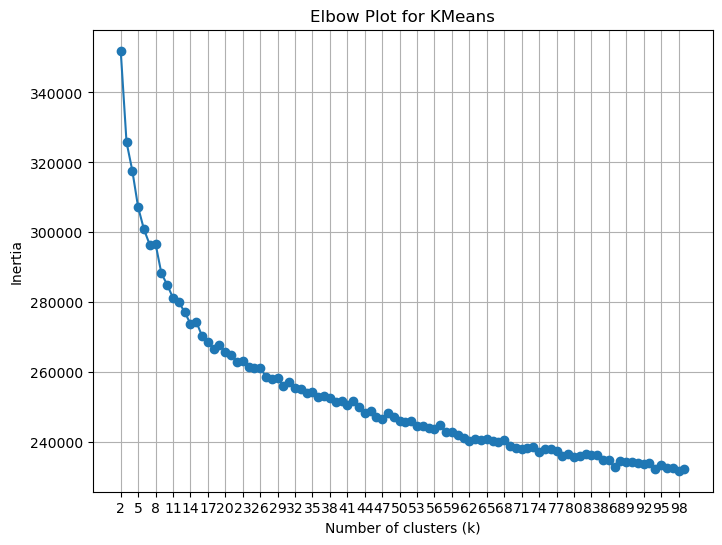

In [126]:
plt.figure(figsize=(8, 6))
plt.plot(k_values, sse, marker='o')
plt.title('Elbow Plot for KMeans')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.xticks(np.arange(min(k_values), max(k_values)+1, 3))
plt.grid(True)
plt.show()

In [127]:
res(32)

C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


,precision,recall,f1-score,support
car,0.458333,0.196429,0.275000,112.0
harbor,1.000000,0.000000,0.000000,111.0
helicopter,0.551020,0.658537,0.600000,82.0
oil_gas_field,1.000000,0.000000,0.000000,110.0
parking_lot,0.062500,0.071429,0.066667,112.0
plane,0.696970,0.207207,0.319444,111.0
runway_mark,0.208333,0.300000,0.245902,100.0
ship,0.250000,0.009009,0.017391,111.0
stadium,0.136602,0.742857,0.230769,105.0
storage_tank,0.318182,0.063063,0.105263,111.0


Here precision is very low

Because of smalll cluster size, we are not getting representative samples for all classes.

### Extending the Centroid label to whole cluster

In [196]:
def res1(k, X_train=X_train, X_test=X_test, y_train_dum=y_train_dum, y_test_dum=y_test_dum, clss_lst=clss_lst):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_train)
    centroids = kmeans.cluster_centers_                        # KMeans clustering
    
    
    data_cen = []
    y_lab = []
    for cen in centroids:
        dis = cdist([cen], X_train)
        closest_ind = np.argmin(dis)
        cen1 = X_train.iloc[closest_ind].values
        p = y_train_dum.iloc[closest_ind].values
        data_cen.append(cen1)
        y_lab.append(p)
    y_lab1=[]
    for x in X_train.values:
        dis = cdist([x], data_cen)
        ind=np.argmin(dis)
        y_lab1.append(y_lab[ind])
                                                                                    # Fit MLP using centroids
    mlp = MLPClassifier()  
    mlp.fit(X_train, y_lab1)

                                                                              # Predict using MLP on test data
    y_pred = mlp.predict(X_test)

                                                                                   # Evaluate MLP performance
    mlp_rpt = classification_report(y_test_dum, y_pred, output_dict=True,
                                    target_names=clss_lst, zero_division=1)
    
    mlp_results1 = pd.DataFrame(mlp_rpt).T
    return mlp_results1

In [197]:
res1(10)

,precision,recall,f1-score,support
car,1.000000,0.000000,0.000000,112.0
harbor,1.000000,0.000000,0.000000,111.0
helicopter,1.000000,0.000000,0.000000,82.0
oil_gas_field,1.000000,0.000000,0.000000,110.0
parking_lot,0.017621,0.035714,0.023599,112.0
plane,1.000000,0.000000,0.000000,111.0
runway_mark,0.042553,0.020000,0.027211,100.0
ship,1.000000,0.000000,0.000000,111.0
stadium,0.126103,0.952381,0.222717,105.0
storage_tank,1.000000,0.000000,0.000000,111.0


In [199]:
res1(20)

C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,precision,recall,f1-score,support
car,1.000000,0.000000,0.000000,112.0
harbor,1.000000,0.000000,0.000000,111.0
helicopter,0.672727,0.451220,0.540146,82.0
oil_gas_field,0.352000,0.400000,0.374468,110.0
parking_lot,0.058824,0.026786,0.036810,112.0
plane,1.000000,0.000000,0.000000,111.0
runway_mark,0.027027,0.030000,0.028436,100.0
ship,1.000000,0.000000,0.000000,111.0
stadium,0.121083,0.809524,0.210657,105.0
storage_tank,1.000000,0.081081,0.150000,111.0


In [200]:
res1(50)

C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,precision,recall,f1-score,support
car,0.760000,0.169643,0.277372,112.0
harbor,1.000000,0.000000,0.000000,111.0
helicopter,0.594937,0.573171,0.583851,82.0
oil_gas_field,0.533333,0.145455,0.228571,110.0
parking_lot,0.038462,0.017857,0.024390,112.0
plane,1.000000,0.207207,0.343284,111.0
runway_mark,0.255102,0.500000,0.337838,100.0
ship,1.000000,0.000000,0.000000,111.0
stadium,0.124590,0.723810,0.212587,105.0
storage_tank,0.937500,0.135135,0.236220,111.0


## MLP using 20% of Nearby Points in Centroid Labels

In [294]:
X_train=X_train.reshape(X_train.shape[0], -1)
X_test=X_test.reshape(X_test.shape[0], -1)

In [296]:
def res2(k, X_train = X_train, X_test = X_test, y_train_dum = y_train, y_test_dum = y_test, clss_lst = clss_lst):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_train)
    centroids = kmeans.cluster_centers_
    
    data_cen = []
    y_lab = []
    for cen in centroids:
        dis = cdist([cen], X_train)
        closest_ind = np.argmin(dis)
        cen1 = X_train[closest_ind]
        p = y_train_dum[closest_ind]
        data_cen.append(tuple(cen1))
        y_lab.append(p)
    y_lab = [item for item in y_lab]
    distan = dict.fromkeys(data_cen, [])

    i = -1
    for x in X_train:
        i += 1
        d = cdist([x], data_cen)
        inde = np.argmin(d[0])
        distan[tuple(data_cen[inde])] = distan[tuple(data_cen[inde])] + [[d[0][inde], i]]

    new_x, new_y, i = [], [], -1
    for cen in distan:
        i += 1
        cutoff = np.percentile([a for (a, b) in distan[cen]], 20)
        for tu in distan[cen]:
            if tu[0] <= cutoff:
                new_x.append(X_train[tu[1]])
                new_y.append(y_lab[i])

    mlp = MLPClassifier()  
    mlp.fit(new_x, new_y)
    y_pred = mlp.predict(X_test)
    mlp_rpt = classification_report(y_test_dum, y_pred, output_dict=True,
                                    target_names=clss_lst, zero_division=1)
    mlp_results1 = pd.DataFrame(mlp_rpt).T
    return mlp_results1

In [297]:
res2(50)

,precision,recall,f1-score,support
car,0.307692,0.214286,0.252632,112.000000
harbor,1.000000,0.000000,0.000000,111.000000
helicopter,0.167939,0.268293,0.206573,82.000000
oil_gas_field,1.000000,0.000000,0.000000,110.000000
parking_lot,0.064516,0.017857,0.027972,112.000000
plane,0.454545,0.225225,0.301205,111.000000
runway_mark,0.062176,0.120000,0.081911,100.000000
ship,0.000000,0.000000,0.000000,111.000000
stadium,0.167756,0.733333,0.273050,105.000000
storage_tank,0.117647,0.090090,0.102041,111.000000


In [298]:
res2(100)

C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,precision,recall,f1-score,support
car,0.615385,0.214286,0.317881,112.0000
harbor,1.000000,0.009009,0.017857,111.0000
helicopter,0.052632,0.012195,0.019802,82.0000
oil_gas_field,0.000000,0.000000,0.000000,110.0000
parking_lot,0.000000,0.000000,0.000000,112.0000
plane,0.000000,0.000000,0.000000,111.0000
runway_mark,0.012987,0.010000,0.011299,100.0000
ship,0.304348,0.063063,0.104478,111.0000
stadium,0.116494,0.961905,0.207819,105.0000
storage_tank,0.090909,0.009009,0.016393,111.0000


In [299]:
res2(30)

,precision,recall,f1-score,support
car,1.000000,0.000000,0.000000,112.000000
harbor,1.000000,0.000000,0.000000,111.000000
helicopter,0.229508,0.512195,0.316981,82.000000
oil_gas_field,0.035714,0.009091,0.014493,110.000000
parking_lot,0.191919,0.169643,0.180095,112.000000
plane,0.628571,0.198198,0.301370,111.000000
runway_mark,0.024390,0.020000,0.021978,100.000000
ship,1.000000,0.000000,0.000000,111.000000
stadium,0.136585,0.800000,0.233333,105.000000
storage_tank,0.086957,0.018018,0.029851,111.000000


In [300]:
res2(50)

,precision,recall,f1-score,support
car,0.204545,0.080357,0.115385,112.000000
harbor,0.000000,0.000000,0.000000,111.000000
helicopter,0.084746,0.182927,0.115830,82.000000
oil_gas_field,0.181818,0.036364,0.060606,110.000000
parking_lot,0.150000,0.080357,0.104651,112.000000
plane,0.068027,0.090090,0.077519,111.000000
runway_mark,0.144737,0.220000,0.174603,100.000000
ship,1.000000,0.000000,0.000000,111.000000
stadium,0.106936,0.352381,0.164080,105.000000
storage_tank,0.098214,0.099099,0.098655,111.000000


# Experimentation with Neural Network Architectures Using Keras

In [238]:
import tensorflow as tf
from tensorflow import keras
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense,Flatten
from keras.optimizers import Adam

In [239]:
X_train=train.drop('label', axis=1).values.reshape(-1, 28, 28)
y_train= train['label']
X_test=test.drop('label', axis=1).values.reshape(-1, 28, 28)
y_test=test['label']

In [240]:
model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(300, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(500, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(100, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(200, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(10, activation='softmax')
])

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [241]:
model.compile(loss="sparse_categorical_crossentropy",
 optimizer=Adam(),
 metrics=["accuracy"])


In [242]:
 history = model.fit(X_train, y_train, epochs=50,
validation_data=(X_test, y_test))
 

Epoch 1/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.2268 - loss: 16.1983 - val_accuracy: 0.3521 - val_loss: 2.7041
Epoch 2/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4120 - loss: 2.4459 - val_accuracy: 0.4545 - val_loss: 2.3381
Epoch 3/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4676 - loss: 2.2668 - val_accuracy: 0.4582 - val_loss: 2.2464
Epoch 4/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5108 - loss: 2.1206 - val_accuracy: 0.5108 - val_loss: 2.1306
Epoch 5/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5474 - loss: 2.0136 - val_accuracy: 0.5052 - val_loss: 2.1452
Epoch 6/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5480 - loss: 1.9479 - val_accuracy: 0.5249 - val_loss: 2.0175
Epoch 7/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5642 - loss: 1.8669 - val_accuracy: 0.5728 - val_loss: 1.9100
Epoch 8/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5583 - loss: 1.8447 - val_accuracy: 0

In [243]:
def grph(history):
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

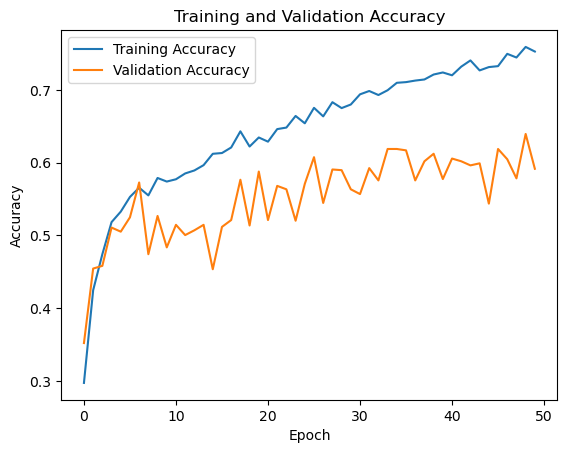

In [244]:
grph(history)

In [258]:
model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(300, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.0001, l2=0.0001)),
    Dense(500, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.0001, l2=0.0001)),
    Dense(100, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.0001, l2=0.0001)),
    Dense(200, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.0001, l2=0.0001)),
    Dense(10, activation='softmax')
])

In [259]:
model.compile(loss="sparse_categorical_crossentropy",
 optimizer=Adam(),
 metrics=["accuracy"])


In [260]:
history = model.fit(X_train, y_train, epochs=50,
validation_data=(X_test, y_test))

Epoch 1/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.2003 - loss: 14.3211 - val_accuracy: 0.3277 - val_loss: 3.5960
Epoch 2/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3313 - loss: 3.4018 - val_accuracy: 0.3812 - val_loss: 3.2945
Epoch 3/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4337 - loss: 3.0998 - val_accuracy: 0.5033 - val_loss: 2.9651
Epoch 4/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4928 - loss: 2.9017 - val_accuracy: 0.4235 - val_loss: 2.9770
Epoch 5/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4936 - loss: 2.8084 - val_accuracy: 0.4864 - val_loss: 2.8249
Epoch 6/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5476 - loss: 2.5818 - val_accuracy: 0.5286 - val_loss: 2.6425
Epoch 7/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5293 - loss: 2.5690 - val_accuracy: 0.4845 - val_loss: 2.6851
Epoch 8/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5472 - loss: 2.4699 - val_accuracy: 0

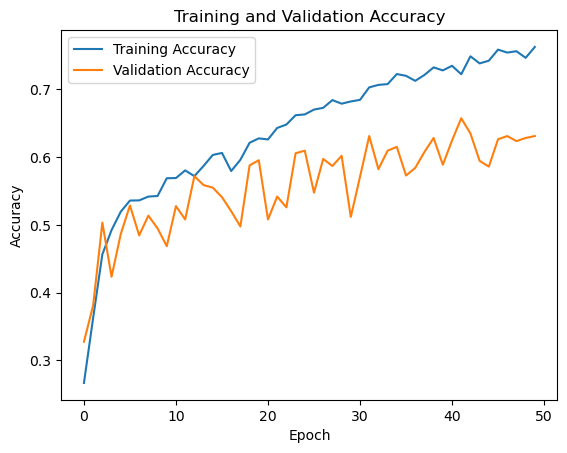

In [261]:
grph(history)